In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [3]:
ROOT_DIR = os.path.abspath("../../")
ROOT_DIR

'C:\\Users\\hp\\Desktop\\push'

In [4]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.nails import nails

%matplotlib inline 

Using TensorFlow backend.


In [5]:
# Path to Nails trained weights

#NAILS_WEIGHTS_PATH = "mask_rcnn_nails_0005.h5"  # TODO: update this path

In [6]:
config = nails.NailsConfig()
NAILS_DIR = os.path.join(ROOT_DIR, "samples\nails\imagedataset")

In [7]:
NAILS_DIR = 'C:\\Users\\hp\\Desktop\\push\\samples\\nails\\imagedataset'

In [8]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [10]:
def get_ax(rows=1, cols=1, size=16):

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [11]:
# Load validation dataset
dataset = nails.NailsDataset()
dataset.load_nails(NAILS_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3
Classes: ['BG', 'nails']


In [12]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")


In [13]:
MODEL_DIR

'C:\\Users\\hp\\Desktop\\push\\logs'

In [14]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0925 06:52:04.488118 22524 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0925 06:52:04.614156 22524 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0925 06:52:04.855730 22524 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0925 06:52:05.084883 22524 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0925 06:52:05.121751 22524 deprecation_wrapper.py:119]

In [15]:
weights_path = model.find_last()

In [16]:
weights_path 


'C:\\Users\\hp\\Desktop\\push\\logs\\nails20190910T2317\\mask_rcnn_nails_0015.h5'

In [17]:
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  C:\Users\hp\Desktop\push\logs\nails20190910T2317\mask_rcnn_nails_0015.h5
Re-starting from epoch 15


In [18]:

# Load validation dataset
dataset = nails.NailsDataset()
dataset.load_nails(NAILS_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3
Classes: ['BG', 'nails']


In [19]:
dataset.image_ids

array([0, 1, 2])

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  133.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:  324.00000  max:  883.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  uint8


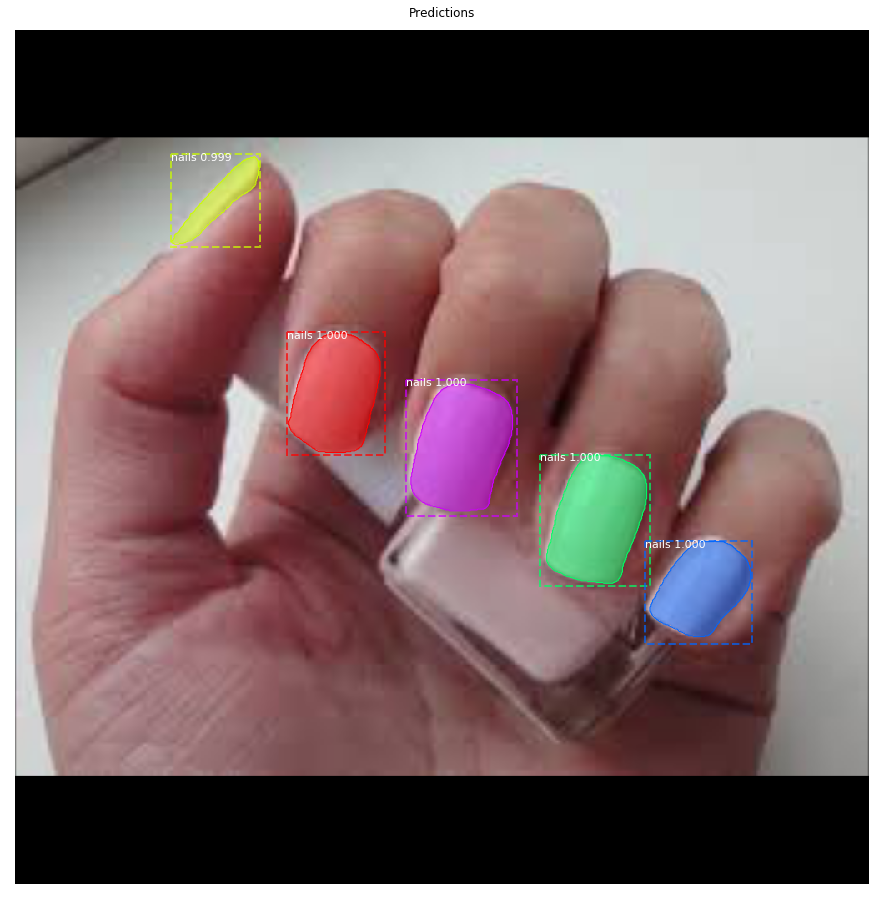

In [20]:
image_id = 1
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
#info = dataset.image_info[image_id]
#print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id,dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)



In [21]:
import skimage

In [56]:
image = skimage.io.imread('my.jpg')

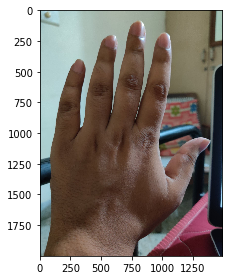

In [23]:
skimage.io.imshow(image)

In [24]:
results = model.detect([image], verbose =1)

r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

Processing 1 images
image                    shape: (2000, 1488, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2000.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


gt_class_id              shape: (4,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (4, 4)                min:  324.00000  max:  883.00000  int32
gt_mask                  shape: (1024, 1024, 4)       min:    0.00000  max:    1.00000  uint8


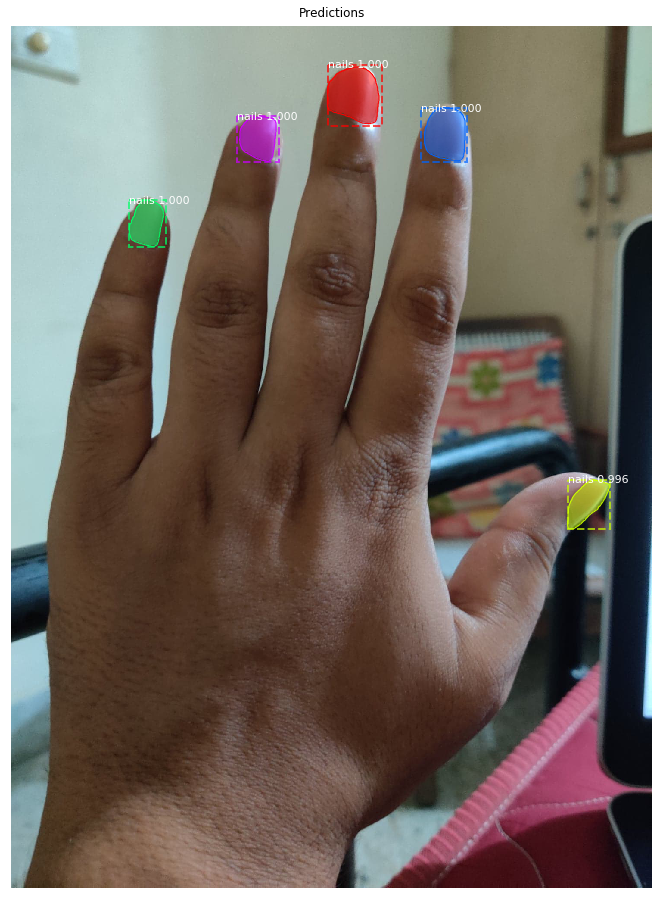

In [25]:
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Basic Application of Uniform Shade On Nails

In [47]:
def apply_shade(image,mask,shade):
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask,shade,image).astype(np.uint8)
    return splash

In [63]:
shade = skimage.io.imread('global.jpg')

In [61]:
from skimage.transform import resize
shade = resize(shade, image.shape)

In [54]:
after_shade = apply_shade(image,r['masks'],shade)

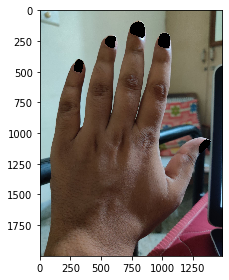

In [55]:
skimage.io.imshow(after_shade)